<a href="https://colab.research.google.com/github/eteitelbaum/code-satp/blob/main/model-data-size-experiments/exp_perpetrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependecies**

In [1]:
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:

import torch


# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")



GPU is available. Using: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
# Assuming your CSV file is named 'conflict_data.csv'
df = pd.read_csv('/content/drive/MyDrive/SATP_data/perpetrator.csv')

# Select only the necessary columns
df = df[['incident_summary', 'perpetrator']]

# Drop rows with missing values
df.dropna(inplace=True)

# Assuming your DataFrame is named 'df'
unique_perpetrators = df['perpetrator'].unique()

# Display the unique values
print("Unique values in 'perpetrator':")
print(unique_perpetrators)

Unique values in 'perpetrator':
['Security' 'Maoist' 'Unknown']


In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from torch.utils.data import Dataset

# -------------------------------------------------------
# 1. Dataset for Single-Label Multi-Class Classification
# -------------------------------------------------------
class SingleLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Args:
            texts: List of text strings.
            labels: List of integer class labels (e.g., [0, 1, 2, ...]).
            tokenizer: A Hugging Face AutoTokenizer.
            max_length: Max sequence length for tokenization.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Squeeze batch dimension
        item = {k: v.squeeze() for k, v in encoding.items()}
        # Integer labels for cross-entropy
        item["labels"] = torch.tensor(label, dtype=torch.long)

        return item

# -------------------------------------------------------
# 2. Custom Metric Function
# -------------------------------------------------------
def compute_metricss(eval_pred, label_names=None):
    """
    Computes accuracy and micro/macro precision/recall/F1 for multi-class classification.
    """
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=1).numpy()

    # Accuracy
    acc = accuracy_score(labels, preds)

    # Classification Report (optionally naming classes)
    report = classification_report(
        labels,
        preds,
        target_names=label_names if label_names else None,
        zero_division=0,
        output_dict=True
    )

    if label_names:
        print("\nFull Classification Report:\n",
              classification_report(labels, preds, target_names=label_names, zero_division=0))
    else:
        print("\nFull Classification Report:\n",
              classification_report(labels, preds, zero_division=0))
    return {
        "accuracy": acc,
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"],
        "precision_weighted": report["weighted avg"]["precision"],
        "recall_weighted": report["weighted avg"]["recall"],
        "f1_weighted": report["weighted avg"]["f1-score"],
    }

# -------------------------------------------------------
# 3. Main Training Function with Train/Val/Test Splits
# -------------------------------------------------------
def train_multiclass_model_3way_split(
    df,
    text_col="incident_summary",
    label_col="perpetrator",
    model_name="bert-base-uncased",
    test_size=0.1,
    val_size=0.1,
    epochs=2,
    batch_size=8
):
    """
    Trains a multi-class classifier with separate train, val, and test sets.

    Args:
        data_path (str): CSV file path. Must contain `text_col` and `label_col`.
        text_col (str): Name of the column containing the text.
        label_col (str): Name of the column containing the class label (string form).
        model_name (str): HF model identifier, e.g. 'bert-base-uncased', 'roberta-base', etc.
        test_size (float): Fraction of entire dataset to hold out for final test set.
        val_size (float): Fraction of entire dataset to hold out for validation set
                          (relative to total, not just leftover).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training and evaluation.

    Returns:
        model: The trained model (same as trainer.model).
        tokenizer: The tokenizer used.
        test_metrics: Evaluation metrics on the test set.
    """

    # 1. Load the data
    # df = pd.read_csv(data_path)

    # 2. Convert label from string to integer IDs
    unique_labels = df[label_col].unique()
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}

    df["label_id"] = df[label_col].map(label2id)

    # 3. Create initial train+val vs test split
    #    e.g. if test_size=0.1, then 10% of data is test, 90% is train+val
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        random_state=42,
        stratify=df["label_id"]  # optional, if you want stratified splits
    )

    # 4. From the train_val_df, create train vs val split
    #    val_size is fraction of the entire dataset, so the fraction
    #    within train_val_df is val_size / (1 - test_size).
    val_fraction_of_trainval = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_fraction_of_trainval,
        random_state=42,
        stratify=train_val_df["label_id"]
    )

    # 5. Prepare data lists
    train_texts = train_df[text_col].tolist()
    train_labels = train_df["label_id"].tolist()

    val_texts = val_df[text_col].tolist()
    val_labels = val_df["label_id"].tolist()

    test_texts = test_df[text_col].tolist()
    test_labels = test_df["label_id"].tolist()

    # 6. Tokenizer & Model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    num_labels = len(unique_labels)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    model.to(device)


    # 7. Create Dataset objects
    train_dataset = SingleLabelDataset(train_texts, train_labels, tokenizer)
    val_dataset = SingleLabelDataset(val_texts, val_labels, tokenizer)
    test_dataset = SingleLabelDataset(test_texts, test_labels, tokenizer)

    # 8. Training Arguments
    training_args = TrainingArguments(
        output_dir="./model_output",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        report_to="none",
        load_best_model_at_end=False  # set to True if you'd like to restore best checkpoint
    )

    # 9. Create Trainer
    label_names = [id2label[i] for i in range(num_labels)]

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda eval_pred: compute_metricss(eval_pred, label_names=label_names)
    )

    # 10. Train
    trainer.train()

    # 11. Evaluate on the test set
    #     By default, trainer.evaluate() returns a dictionary of metric values
    test_metrics = trainer.evaluate(test_dataset)

    print("\nTest Set Evaluation Results:", test_metrics)

    # Return the final model, tokenizer, and test set metrics
    return trainer.model, tokenizer, test_metrics



In [ ]:


# model, tokenizer, test_metrics = train_multiclass_model_3way_split(
#     df,
#     text_col="incident_summary",
#     label_col="perpetrator",
#     model_name="bert-base-uncased",
#     test_size=0.1,   # 10% of data
#     val_size=0.1,    # 10% of data
#     epochs=2,
#     batch_size=32
# )

# print("Test Accuracy:", test_metrics["eval_accuracy"])


# **Grid loop for Training**

In [6]:
fraction_labels = {
    1/32: "3%",   # 1/32 = 3.125%
    1/16: "6%",   # 1/16 = 6.25%
    1/8:  "12%",  # 1/8  = 12.5%
    1/4:  "25%",
    1/2:  "50%",
    1.0:  "100%"
}

model_name_labels = {
    "bert-base-uncased": "BERT Base (uncased)",
    "snowood1/ConfliBERT-scr-uncased": "ConfliBERT-scr-uncased",
    "roberta-base": "RoBERTa Base",
    "distilbert-base-uncased": "DistilBERT (uncased)",
    "xlnet-base-cased": "XLNet Base (cased)",
    "google/electra-base-discriminator": "ELECTRA Base"
}


In [7]:
fractions = [1/32, 1/16, 1/8, 1/4, 1/2, 1.0]

models_list = [
    "bert-base-uncased",
    "snowood1/ConfliBERT-scr-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "xlnet-base-cased",
    "google/electra-base-discriminator"
]


In [8]:
import pandas as pd

def run_all_experiments_and_save(df_full, output_csv="experiment_results.csv"):
    """
    1. Iterates over the defined fractions & model list
    2. Samples df_full according to fraction
    3. Trains & evaluates using train_multiclass_model_3way_split
    4. Saves the collected results in a DataFrame
    5. Exports to CSV

    Args:
        df_full (pd.DataFrame): Full dataset with columns [label_col, text_col].
        output_csv (str): File path to save the experiment results.
    Returns:
        results_df (pd.DataFrame): Contains experiment results for analysis.
    """
    results_list = []

    for frac in fractions:
        # Sample a fraction of the data
        subset_size = int(len(df_full) * frac)
        df_subset = df_full.sample(n=subset_size, random_state=42)

        # Friendly fraction label if you want
        frac_label = fraction_labels.get(frac, f"{frac*100:.1f}%")
        print(f"\n=== DATA FRACTION: {frac} ({subset_size} rows) ===")

        for model_name in models_list:
            # Model label
            model_label = model_name_labels.get(model_name, model_name)
            print(f"Training model: {model_label}")

            # Train & evaluate
            model, tokenizer, test_metrics = train_multiclass_model_3way_split(
                df_subset,
                text_col="incident_summary",
                label_col="perpetrator",
                model_name=model_name,
                test_size=0.1,   # 10% for test
                val_size=0.1,   # 10% for val
                epochs=2,
                batch_size=32
            )

            # Build a result dict
            run_result = {
                "fraction_raw": frac,
                "fraction_label": frac_label,
                "subset_size": subset_size,
                "model_raw": model_name,
                "model_label": model_label
            }

            # Merge test_metrics (e.g., accuracy, macro-F1, etc.)
            for k, v in test_metrics.items():
                run_result[k] = v

            # Append to results_list
            results_list.append(run_result)

    # Convert to DataFrame
    results_df = pd.DataFrame(results_list)
    # Save to CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nResults saved to {output_csv}")

    # (Optionally, also save to JSON if desired)
    # results_df.to_json("experiment_results.json", orient="records")

    return results_df


In [9]:

#
# Example usage:
final_results_df = run_all_experiments_and_save(df, output_csv="experiment_results.csv")

# Now you can inspect final_results_df in Python:
print(final_results_df.head())

# If you want to do more analysis, you can pivot, group, or plot the data.



=== DATA FRACTION: 0.03125 (309 rows) ===
Training model: BERT Base (uncased)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,No log,0.838489,0.645161,0.477778,0.431548,0.410569,0.686022,0.645161,0.603462
2,1.001500,0.777730,0.806452,0.536415,0.553571,0.544733,0.779886,0.806452,0.792766



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.60      0.94      0.73        16
    Security       0.83      0.36      0.50        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.65        31
   macro avg       0.48      0.43      0.41        31
weighted avg       0.69      0.65      0.60        31


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.82      0.88      0.85        16
    Security       0.79      0.79      0.79        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.81        31
   macro avg       0.54      0.55      0.54        31
weighted avg       0.78      0.81      0.79        31




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.83      0.94      0.88        16
    Security       0.92      0.86      0.89        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.87        31
   macro avg       0.59      0.60      0.59        31
weighted avg       0.85      0.87      0.86        31


Test Set Evaluation Results: {'eval_loss': 0.7557793855667114, 'eval_accuracy': 0.8709677419354839, 'eval_precision_macro': 0.5854700854700855, 'eval_recall_macro': 0.5982142857142857, 'eval_f1_macro': 0.5904139433551198, 'eval_precision_weighted': 0.8469809760132341, 'eval_recall_weighted': 0.8709677419354839, 'eval_f1_weighted': 0.856841661395741, 'eval_runtime': 0.3189, 'eval_samples_per_second': 97.205, 'eval_steps_per_second': 3.136, 'epoch': 2.0}
Training model: ConfliBERT-scr-uncased


tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/454k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,No log,0.645908,0.774194,0.565217,0.523810,0.515929,0.810659,0.774194,0.751936
2,0.877300,0.504414,0.967742,0.644444,0.666667,0.655172,0.937634,0.967742,0.952169



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.70      1.00      0.82        16
    Security       1.00      0.57      0.73        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.77        31
   macro avg       0.57      0.52      0.52        31
weighted avg       0.81      0.77      0.75        31


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       1.00      1.00      1.00        16
    Security       0.93      1.00      0.97        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.97        31
   macro avg       0.64      0.67      0.66        31
weighted avg       0.94      0.97      0.95        31




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      0.94      0.94        16
    Security       0.87      0.93      0.90        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.90        31
   macro avg       0.60      0.62      0.61        31
weighted avg       0.88      0.90      0.89        31


Test Set Evaluation Results: {'eval_loss': 0.5573581457138062, 'eval_accuracy': 0.9032258064516129, 'eval_precision_macro': 0.6013888888888889, 'eval_recall_macro': 0.6220238095238095, 'eval_f1_macro': 0.6113505747126436, 'eval_precision_weighted': 0.875268817204301, 'eval_recall_weighted': 0.9032258064516129, 'eval_f1_weighted': 0.8887652947719689, 'eval_runtime': 0.2796, 'eval_samples_per_second': 110.855, 'eval_steps_per_second': 3.576, 'epoch': 2.0}
Training model: RoBERTa Base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,No log,0.800179,0.516129,0.172043,0.333333,0.226950,0.266389,0.516129,0.351407
2,0.970800,0.749459,0.838710,0.578947,0.583333,0.568543,0.848896,0.838710,0.825583



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.52      1.00      0.68        16
    Security       0.00      0.00      0.00        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.52        31
   macro avg       0.17      0.33      0.23        31
weighted avg       0.27      0.52      0.35        31


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       1.00      0.75      0.86        16
    Security       0.74      1.00      0.85        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.84        31
   macro avg       0.58      0.58      0.57        31
weighted avg       0.85      0.84      0.83        31




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.78      0.44      0.56        16
    Security       0.59      0.93      0.72        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.65        31
   macro avg       0.46      0.46      0.43        31
weighted avg       0.67      0.65      0.62        31


Test Set Evaluation Results: {'eval_loss': 0.7775496244430542, 'eval_accuracy': 0.6451612903225806, 'eval_precision_macro': 0.45622895622895626, 'eval_recall_macro': 0.45535714285714285, 'eval_f1_macro': 0.42740740740740746, 'eval_precision_weighted': 0.6682958618442489, 'eval_recall_weighted': 0.6451612903225806, 'eval_f1_weighted': 0.6151971326164875, 'eval_runtime': 0.2841, 'eval_samples_per_second': 109.114, 'eval_steps_per_second': 3.52, 'epoch': 2.0}
Training model: DistilBERT (uncased)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,No log,0.796852,0.677419,0.538462,0.452381,0.429407,0.769231,0.677419,0.630932
2,0.934400,0.733779,0.806452,0.538889,0.556548,0.546237,0.786022,0.806452,0.794173



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.62      1.00      0.76        16
    Security       1.00      0.36      0.53        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.68        31
   macro avg       0.54      0.45      0.43        31
weighted avg       0.77      0.68      0.63        31


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.87      0.81      0.84        16
    Security       0.75      0.86      0.80        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.81        31
   macro avg       0.54      0.56      0.55        31
weighted avg       0.79      0.81      0.79        31




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.80      0.75      0.77        16
    Security       0.75      0.86      0.80        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.77        31
   macro avg       0.52      0.54      0.52        31
weighted avg       0.75      0.77      0.76        31


Test Set Evaluation Results: {'eval_loss': 0.7493188381195068, 'eval_accuracy': 0.7741935483870968, 'eval_precision_macro': 0.5166666666666667, 'eval_recall_macro': 0.5357142857142857, 'eval_f1_macro': 0.524731182795699, 'eval_precision_weighted': 0.7516129032258064, 'eval_recall_weighted': 0.7741935483870968, 'eval_f1_weighted': 0.7608740894901145, 'eval_runtime': 0.2167, 'eval_samples_per_second': 143.071, 'eval_steps_per_second': 4.615, 'epoch': 2.0}
Training model: XLNet Base (cased)


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,No log,0.780175,0.516129,0.172043,0.333333,0.226950,0.266389,0.516129,0.351407
2,0.925400,0.739938,0.612903,0.464444,0.437500,0.390831,0.683011,0.612903,0.558839


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.52      1.00      0.68        16
    Security       0.00      0.00      0.00        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.52        31
   macro avg       0.17      0.33      0.23        31
weighted avg       0.27      0.52      0.35        31


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.83      0.31      0.45        16
    Security       0.56      1.00      0.72        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.61        31
   macro avg       0.46      0.44      0.39        31
weighted avg       0.68      0.61      0.56        31




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.75      0.19      0.30        16
    Security       0.48      0.93      0.63        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.52        31
   macro avg       0.41      0.37      0.31        31
weighted avg       0.60      0.52      0.44        31


Test Set Evaluation Results: {'eval_loss': 0.8004509806632996, 'eval_accuracy': 0.5161290322580645, 'eval_precision_macro': 0.4104938271604938, 'eval_recall_macro': 0.37202380952380953, 'eval_f1_macro': 0.3113821138211382, 'eval_precision_weighted': 0.6045400238948626, 'eval_recall_weighted': 0.5161290322580645, 'eval_f1_weighted': 0.4412273800157357, 'eval_runtime': 0.4493, 'eval_samples_per_second': 69.0, 'eval_steps_per_second': 2.226, 'epoch': 2.0}
Training model: ELECTRA Base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,No log,0.801296,0.580645,0.517241,0.380952,0.320370,0.736374,0.580645,0.479928
2,0.940900,0.737130,0.838710,0.587302,0.571429,0.566066,0.844854,0.838710,0.822726


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.55      1.00      0.71        16
    Security       1.00      0.14      0.25        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.58        31
   macro avg       0.52      0.38      0.32        31
weighted avg       0.74      0.58      0.48        31


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.76      1.00      0.86        16
    Security       1.00      0.71      0.83        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.84        31
   macro avg       0.59      0.57      0.57        31
weighted avg       0.84      0.84      0.82        31




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.79      0.94      0.86        16
    Security       0.92      0.79      0.85        14
     Unknown       0.00      0.00      0.00         1

    accuracy                           0.84        31
   macro avg       0.57      0.57      0.57        31
weighted avg       0.82      0.84      0.82        31


Test Set Evaluation Results: {'eval_loss': 0.7571452856063843, 'eval_accuracy': 0.8387096774193549, 'eval_precision_macro': 0.5687134502923977, 'eval_recall_macro': 0.5744047619047619, 'eval_f1_macro': 0.5677655677655677, 'eval_precision_weighted': 0.8214487832484436, 'eval_recall_weighted': 0.8387096774193549, 'eval_f1_weighted': 0.8245303084012762, 'eval_runtime': 0.3173, 'eval_samples_per_second': 97.698, 'eval_steps_per_second': 3.152, 'epoch': 2.0}

=== DATA FRACTION: 0.0625 (619 rows) ===
Training model: BERT Base (uncased)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.908100,0.669129,0.870968,0.600000,0.604938,0.595616,0.848387,0.870968,0.849828
2,0.560900,0.445472,0.887097,0.606838,0.617284,0.607136,0.858974,0.887097,0.865888



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.80      1.00      0.89        32
    Security       1.00      0.81      0.90        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.87        62
   macro avg       0.60      0.60      0.60        62
weighted avg       0.85      0.87      0.85        62


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.82      1.00      0.90        32
    Security       1.00      0.85      0.92        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.89        62
   macro avg       0.61      0.62      0.61        62
weighted avg       0.86      0.89      0.87        62




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.84      0.97      0.90        32
    Security       0.96      0.89      0.92        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.89        62
   macro avg       0.60      0.62      0.61        62
weighted avg       0.85      0.89      0.87        62


Test Set Evaluation Results: {'eval_loss': 0.4044155180454254, 'eval_accuracy': 0.8870967741935484, 'eval_precision_macro': 0.5992792792792793, 'eval_recall_macro': 0.6192129629629629, 'eval_f1_macro': 0.6072092159048681, 'eval_precision_weighted': 0.8504969485614646, 'eval_recall_weighted': 0.8870967741935484, 'eval_f1_weighted': 0.86575322760456, 'eval_runtime': 0.5355, 'eval_samples_per_second': 115.777, 'eval_steps_per_second': 3.735, 'epoch': 2.0}
Training model: ConfliBERT-scr-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.856100,0.586176,0.838710,0.587302,0.580247,0.571976,0.828725,0.838710,0.817006
2,0.445900,0.309177,0.919355,0.613404,0.641975,0.627050,0.875115,0.919355,0.896245



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.76      1.00      0.86        32
    Security       1.00      0.74      0.85        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.84        62
   macro avg       0.59      0.58      0.57        62
weighted avg       0.83      0.84      0.82        62


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      1.00      0.96        32
    Security       0.93      0.93      0.93        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.92        62
   macro avg       0.61      0.64      0.63        62
weighted avg       0.88      0.92      0.90        62




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      0.97      0.94        32
    Security       0.89      0.93      0.91        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.90        62
   macro avg       0.60      0.63      0.62        62
weighted avg       0.86      0.90      0.88        62


Test Set Evaluation Results: {'eval_loss': 0.3024386763572693, 'eval_accuracy': 0.9032258064516129, 'eval_precision_macro': 0.6015406162464986, 'eval_recall_macro': 0.6315586419753086, 'eval_f1_macro': 0.6161616161616162, 'eval_precision_weighted': 0.8594131200867444, 'eval_recall_weighted': 0.9032258064516129, 'eval_f1_weighted': 0.8807429130009775, 'eval_runtime': 0.4663, 'eval_samples_per_second': 132.965, 'eval_steps_per_second': 4.289, 'epoch': 2.0}
Training model: RoBERTa Base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.921100,0.523991,0.919355,0.614583,0.645833,0.627665,0.883569,0.919355,0.898058
2,0.511600,0.284349,0.935484,0.622083,0.654321,0.637729,0.890923,0.935484,0.912566



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       1.00      0.94      0.97        32
    Security       0.84      1.00      0.92        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.92        62
   macro avg       0.61      0.65      0.63        62
weighted avg       0.88      0.92      0.90        62


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      1.00      0.98        32
    Security       0.90      0.96      0.93        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.94        62
   macro avg       0.62      0.65      0.64        62
weighted avg       0.89      0.94      0.91        62




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.84      0.90        32
    Security       0.79      1.00      0.89        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.87        62
   macro avg       0.59      0.61      0.60        62
weighted avg       0.84      0.87      0.85        62


Test Set Evaluation Results: {'eval_loss': 0.3825935423374176, 'eval_accuracy': 0.8709677419354839, 'eval_precision_macro': 0.5861344537815126, 'eval_recall_macro': 0.6145833333333334, 'eval_f1_macro': 0.5950819672131148, 'eval_precision_weighted': 0.8435212794795338, 'eval_recall_weighted': 0.8709677419354839, 'eval_f1_weighted': 0.8500264410364886, 'eval_runtime': 0.5182, 'eval_samples_per_second': 119.647, 'eval_steps_per_second': 3.86, 'epoch': 2.0}
Training model: DistilBERT (uncased)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.923900,0.665946,0.854839,0.577485,0.594522,0.582820,0.820246,0.854839,0.832854
2,0.561800,0.438175,0.854839,0.569665,0.596451,0.582458,0.813364,0.854839,0.833173



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.82      0.97      0.89        32
    Security       0.92      0.81      0.86        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.85        62
   macro avg       0.58      0.59      0.58        62
weighted avg       0.82      0.85      0.83        62


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.86      0.94      0.90        32
    Security       0.85      0.85      0.85        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.85        62
   macro avg       0.57      0.60      0.58        62
weighted avg       0.81      0.85      0.83        62




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      0.94      0.94        32
    Security       0.87      0.96      0.91        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.90        62
   macro avg       0.60      0.63      0.62        62
weighted avg       0.86      0.90      0.88        62


Test Set Evaluation Results: {'eval_loss': 0.42029863595962524, 'eval_accuracy': 0.9032258064516129, 'eval_precision_macro': 0.6013888888888889, 'eval_recall_macro': 0.6334876543209876, 'eval_f1_macro': 0.616593567251462, 'eval_precision_weighted': 0.8612903225806453, 'eval_recall_weighted': 0.9032258064516129, 'eval_f1_weighted': 0.8811544991511037, 'eval_runtime': 0.3386, 'eval_samples_per_second': 183.115, 'eval_steps_per_second': 5.907, 'epoch': 2.0}
Training model: XLNet Base (cased)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.832300,0.416369,0.870968,0.600000,0.604938,0.595616,0.848387,0.870968,0.849828
2,0.409200,0.299758,0.887097,0.606838,0.617284,0.607136,0.858974,0.887097,0.865888



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.80      1.00      0.89        32
    Security       1.00      0.81      0.90        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.87        62
   macro avg       0.60      0.60      0.60        62
weighted avg       0.85      0.87      0.85        62


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.82      1.00      0.90        32
    Security       1.00      0.85      0.92        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.89        62
   macro avg       0.61      0.62      0.61        62
weighted avg       0.86      0.89      0.87        62




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      0.97      0.94        32
    Security       0.89      0.93      0.91        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.90        62
   macro avg       0.60      0.63      0.62        62
weighted avg       0.86      0.90      0.88        62


Test Set Evaluation Results: {'eval_loss': 0.20878906548023224, 'eval_accuracy': 0.9032258064516129, 'eval_precision_macro': 0.6015406162464986, 'eval_recall_macro': 0.6315586419753086, 'eval_f1_macro': 0.6161616161616162, 'eval_precision_weighted': 0.8594131200867444, 'eval_recall_weighted': 0.9032258064516129, 'eval_f1_weighted': 0.8807429130009775, 'eval_runtime': 0.7694, 'eval_samples_per_second': 80.579, 'eval_steps_per_second': 2.599, 'epoch': 2.0}
Training model: ELECTRA Base


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.907400,0.655154,0.870968,0.592345,0.604938,0.593803,0.840040,0.870968,0.848469
2,0.588100,0.450384,0.903226,0.603989,0.629630,0.615612,0.860766,0.903226,0.880169



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.82      1.00      0.90        32
    Security       0.96      0.81      0.88        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.87        62
   macro avg       0.59      0.60      0.59        62
weighted avg       0.84      0.87      0.85        62


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.89      1.00      0.94        32
    Security       0.92      0.89      0.91        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.90        62
   macro avg       0.60      0.63      0.62        62
weighted avg       0.86      0.90      0.88        62




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      0.97      0.95        32
    Security       0.90      0.96      0.93        27
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.92        62
   macro avg       0.61      0.64      0.63        62
weighted avg       0.88      0.92      0.90        62


Test Set Evaluation Results: {'eval_loss': 0.43302619457244873, 'eval_accuracy': 0.9193548387096774, 'eval_precision_macro': 0.6119818878439568, 'eval_recall_macro': 0.6439043209876543, 'eval_f1_macro': 0.6274725274725275, 'eval_precision_weighted': 0.8752823001988743, 'eval_recall_weighted': 0.9193548387096774, 'eval_f1_weighted': 0.8966855724920242, 'eval_runtime': 0.5266, 'eval_samples_per_second': 117.745, 'eval_steps_per_second': 3.798, 'epoch': 2.0}

=== DATA FRACTION: 0.125 (1239 rows) ===
Training model: BERT Base (uncased)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.398100,0.340353,0.879032,0.745421,0.763117,0.753232,0.882400,0.879032,0.880420
2,0.213700,0.289960,0.895161,0.757407,0.825810,0.780167,0.913978,0.895161,0.902445



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.92      0.94      0.93        64
    Security       0.88      0.85      0.87        54
     Unknown       0.43      0.50      0.46         6

    accuracy                           0.88       124
   macro avg       0.75      0.76      0.75       124
weighted avg       0.88      0.88      0.88       124


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.92      0.95        64
    Security       0.89      0.89      0.89        54
     Unknown       0.40      0.67      0.50         6

    accuracy                           0.90       124
   macro avg       0.76      0.83      0.78       124
weighted avg       0.91      0.90      0.90       124




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.98      0.98        64
    Security       0.91      0.94      0.93        54
     Unknown       0.33      0.17      0.22         6

    accuracy                           0.93       124
   macro avg       0.74      0.70      0.71       124
weighted avg       0.91      0.93      0.92       124


Test Set Evaluation Results: {'eval_loss': 0.2208724021911621, 'eval_accuracy': 0.9274193548387096, 'eval_precision_macro': 0.7377594627594628, 'eval_recall_macro': 0.6984953703703703, 'eval_f1_macro': 0.7087463785138204, 'eval_precision_weighted': 0.9129785537043601, 'eval_recall_weighted': 0.9274193548387096, 'eval_f1_weighted': 0.9186910363954623, 'eval_runtime': 0.8784, 'eval_samples_per_second': 141.168, 'eval_steps_per_second': 4.554, 'epoch': 2.0}
Training model: ConfliBERT-scr-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.392000,0.334731,0.870968,0.582292,0.611690,0.594587,0.837349,0.870968,0.850941
2,0.242200,0.304852,0.887097,0.711293,0.671489,0.681138,0.878239,0.887097,0.879982



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.89      0.92        64
    Security       0.80      0.94      0.86        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.87       124
   macro avg       0.58      0.61      0.59       124
weighted avg       0.84      0.87      0.85       124


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.92      0.94        64
    Security       0.83      0.93      0.88        54
     Unknown       0.33      0.17      0.22         6

    accuracy                           0.89       124
   macro avg       0.71      0.67      0.68       124
weighted avg       0.88      0.89      0.88       124




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.98      0.97        64
    Security       0.90      0.96      0.93        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.93       124
   macro avg       0.62      0.65      0.63       124
weighted avg       0.88      0.93      0.90       124


Test Set Evaluation Results: {'eval_loss': 0.18567654490470886, 'eval_accuracy': 0.9274193548387096, 'eval_precision_macro': 0.6170323928944619, 'eval_recall_macro': 0.6491126543209876, 'eval_f1_macro': 0.6326007326007326, 'eval_precision_weighted': 0.8831024370512692, 'eval_recall_weighted': 0.9274193548387096, 'eval_f1_weighted': 0.9046260191421482, 'eval_runtime': 0.8727, 'eval_samples_per_second': 142.089, 'eval_steps_per_second': 4.584, 'epoch': 2.0}
Training model: RoBERTa Base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.423500,0.406398,0.870968,0.579400,0.609761,0.593995,0.830159,0.870968,0.849794
2,0.236500,0.289615,0.895161,0.717577,0.677662,0.686931,0.887749,0.895161,0.888163



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      0.92      0.91        64
    Security       0.83      0.91      0.87        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.87       124
   macro avg       0.58      0.61      0.59       124
weighted avg       0.83      0.87      0.85       124


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.92      0.95        64
    Security       0.84      0.94      0.89        54
     Unknown       0.33      0.17      0.22         6

    accuracy                           0.90       124
   macro avg       0.72      0.68      0.69       124
weighted avg       0.89      0.90      0.89       124




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.93      1.00      0.96        64
    Security       0.91      0.93      0.92        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.92       124
   macro avg       0.61      0.64      0.63       124
weighted avg       0.87      0.92      0.90       124


Test Set Evaluation Results: {'eval_loss': 0.2284732460975647, 'eval_accuracy': 0.9193548387096774, 'eval_precision_macro': 0.6122090469916557, 'eval_recall_macro': 0.6419753086419754, 'eval_f1_macro': 0.6266124025660481, 'eval_precision_weighted': 0.8746228058991032, 'eval_recall_weighted': 0.9193548387096774, 'eval_f1_weighted': 0.8962521723070623, 'eval_runtime': 0.8469, 'eval_samples_per_second': 146.408, 'eval_steps_per_second': 4.723, 'epoch': 2.0}
Training model: DistilBERT (uncased)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.440300,0.387931,0.838710,0.733085,0.635417,0.655467,0.830071,0.838710,0.828857
2,0.294200,0.343877,0.870968,0.752250,0.807292,0.771604,0.882828,0.870968,0.874813



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.82      0.91      0.86        64
    Security       0.88      0.83      0.86        54
     Unknown       0.50      0.17      0.25         6

    accuracy                           0.84       124
   macro avg       0.73      0.64      0.66       124
weighted avg       0.83      0.84      0.83       124


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.89      0.92      0.91        64
    Security       0.92      0.83      0.87        54
     Unknown       0.44      0.67      0.53         6

    accuracy                           0.87       124
   macro avg       0.75      0.81      0.77       124
weighted avg       0.88      0.87      0.87       124




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.89      0.97      0.93        64
    Security       0.96      0.87      0.91        54
     Unknown       0.20      0.17      0.18         6

    accuracy                           0.89       124
   macro avg       0.68      0.67      0.67       124
weighted avg       0.88      0.89      0.88       124


Test Set Evaluation Results: {'eval_loss': 0.26515400409698486, 'eval_accuracy': 0.8870967741935484, 'eval_precision_macro': 0.6816326530612246, 'eval_recall_macro': 0.6685956790123456, 'eval_f1_macro': 0.6732708917899469, 'eval_precision_weighted': 0.8845292955892033, 'eval_recall_weighted': 0.8870967741935484, 'eval_f1_weighted': 0.8838414764998571, 'eval_runtime': 0.5321, 'eval_samples_per_second': 233.026, 'eval_steps_per_second': 7.517, 'epoch': 2.0}
Training model: XLNet Base (cased)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.460800,0.446267,0.830645,0.559099,0.578897,0.567075,0.794734,0.830645,0.809814
2,0.268500,0.366109,0.895161,0.798421,0.876157,0.827852,0.904724,0.895161,0.898323



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.80      0.92      0.86        64
    Security       0.88      0.81      0.85        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.83       124
   macro avg       0.56      0.58      0.57       124
weighted avg       0.79      0.83      0.81       124


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.91      0.93        64
    Security       0.89      0.89      0.89        54
     Unknown       0.56      0.83      0.67         6

    accuracy                           0.90       124
   macro avg       0.80      0.88      0.83       124
weighted avg       0.90      0.90      0.90       124




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      0.98      0.96        64
    Security       0.91      0.94      0.93        54
     Unknown       1.00      0.17      0.29         6

    accuracy                           0.93       124
   macro avg       0.95      0.70      0.72       124
weighted avg       0.93      0.93      0.91       124


Test Set Evaluation Results: {'eval_loss': 0.21613559126853943, 'eval_accuracy': 0.9274193548387096, 'eval_precision_macro': 0.9503375977256575, 'eval_recall_macro': 0.6984953703703703, 'eval_f1_macro': 0.7249396913519051, 'eval_precision_weighted': 0.9303038379530917, 'eval_recall_weighted': 0.9274193548387096, 'eval_f1_weighted': 0.9140666523823381, 'eval_runtime': 1.4309, 'eval_samples_per_second': 86.658, 'eval_steps_per_second': 2.795, 'epoch': 2.0}
Training model: ELECTRA Base


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.471000,0.395448,0.879032,0.585050,0.615934,0.599895,0.837540,0.879032,0.857502
2,0.271600,0.283075,0.895161,0.599478,0.629244,0.611282,0.862468,0.895161,0.874666



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      0.92      0.91        64
    Security       0.85      0.93      0.88        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.88       124
   macro avg       0.59      0.62      0.60       124
weighted avg       0.84      0.88      0.86       124


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.91      0.94        64
    Security       0.82      0.98      0.89        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.90       124
   macro avg       0.60      0.63      0.61       124
weighted avg       0.86      0.90      0.87       124




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      0.97      0.95        64
    Security       0.88      0.94      0.91        54
     Unknown       0.00      0.00      0.00         6

    accuracy                           0.91       124
   macro avg       0.61      0.64      0.62       124
weighted avg       0.87      0.91      0.89       124


Test Set Evaluation Results: {'eval_loss': 0.26065391302108765, 'eval_accuracy': 0.9112903225806451, 'eval_precision_macro': 0.6062347614071752, 'eval_recall_macro': 0.6377314814814815, 'eval_f1_macro': 0.6215201465201465, 'eval_precision_weighted': 0.8677739575959821, 'eval_recall_weighted': 0.9112903225806451, 'eval_f1_weighted': 0.8889090747961715, 'eval_runtime': 0.8924, 'eval_samples_per_second': 138.955, 'eval_steps_per_second': 4.482, 'epoch': 2.0}

=== DATA FRACTION: 0.25 (2478 rows) ===
Training model: BERT Base (uncased)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.235900,0.275007,0.919355,0.764374,0.721380,0.734093,0.911648,0.919355,0.913101
2,0.115600,0.224533,0.931452,0.837958,0.852030,0.844644,0.932809,0.931452,0.932071



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.92      0.95       131
    Security       0.90      0.99      0.94       105
     Unknown       0.43      0.25      0.32        12

    accuracy                           0.92       248
   macro avg       0.76      0.72      0.73       248
weighted avg       0.91      0.92      0.91       248


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.95      0.95       131
    Security       0.95      0.94      0.95       105
     Unknown       0.62      0.67      0.64        12

    accuracy                           0.93       248
   macro avg       0.84      0.85      0.84       248
weighted avg       0.93      0.93      0.93       248




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.98      0.97       131
    Security       0.96      0.92      0.94       105
     Unknown       0.67      0.67      0.67        12

    accuracy                           0.94       248
   macro avg       0.86      0.86      0.86       248
weighted avg       0.94      0.94      0.94       248


Test Set Evaluation Results: {'eval_loss': 0.13383090496063232, 'eval_accuracy': 0.9435483870967742, 'eval_precision_macro': 0.8608727539420609, 'eval_recall_macro': 0.8584030049678905, 'eval_f1_macro': 0.859446350504092, 'eval_precision_weighted': 0.9436264594201355, 'eval_recall_weighted': 0.9435483870967742, 'eval_f1_weighted': 0.9433211512966571, 'eval_runtime': 1.7437, 'eval_samples_per_second': 142.23, 'eval_steps_per_second': 4.588, 'epoch': 2.0}
Training model: ConfliBERT-scr-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.175100,0.273919,0.907258,0.720193,0.663280,0.664955,0.891218,0.907258,0.893271
2,0.139300,0.233078,0.939516,0.840926,0.882982,0.859150,0.943887,0.939516,0.941259



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.92      0.94       131
    Security       0.86      0.99      0.92       105
     Unknown       0.33      0.08      0.13        12

    accuracy                           0.91       248
   macro avg       0.72      0.66      0.66       248
weighted avg       0.89      0.91      0.89       248


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.95      0.95       131
    Security       0.96      0.95      0.96       105
     Unknown       0.60      0.75      0.67        12

    accuracy                           0.94       248
   macro avg       0.84      0.88      0.86       248
weighted avg       0.94      0.94      0.94       248




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.99      0.98       131
    Security       0.98      0.93      0.96       105
     Unknown       0.71      0.83      0.77        12

    accuracy                           0.96       248
   macro avg       0.89      0.92      0.90       248
weighted avg       0.96      0.96      0.96       248


Test Set Evaluation Results: {'eval_loss': 0.12068403512239456, 'eval_accuracy': 0.9596774193548387, 'eval_precision_macro': 0.8881449893390192, 'eval_recall_macro': 0.9196776929601357, 'eval_f1_macro': 0.9021534685593591, 'eval_precision_weighted': 0.9619394387509458, 'eval_recall_weighted': 0.9596774193548387, 'eval_f1_weighted': 0.9602794960483899, 'eval_runtime': 1.6882, 'eval_samples_per_second': 146.906, 'eval_steps_per_second': 4.739, 'epoch': 2.0}
Training model: RoBERTa Base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.218300,0.245274,0.919355,0.829721,0.766806,0.790927,0.915293,0.919355,0.915730
2,0.153000,0.215691,0.943548,0.868586,0.835690,0.850342,0.941581,0.943548,0.942272



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      0.97      0.94       131
    Security       0.95      0.91      0.93       105
     Unknown       0.62      0.42      0.50        12

    accuracy                           0.92       248
   macro avg       0.83      0.77      0.79       248
weighted avg       0.92      0.92      0.92       248


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.96      0.96       131
    Security       0.94      0.96      0.95       105
     Unknown       0.70      0.58      0.64        12

    accuracy                           0.94       248
   macro avg       0.87      0.84      0.85       248
weighted avg       0.94      0.94      0.94       248




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      1.00      0.97       131
    Security       0.99      0.92      0.96       105
     Unknown       0.64      0.58      0.61        12

    accuracy                           0.95       248
   macro avg       0.86      0.84      0.84       248
weighted avg       0.95      0.95      0.95       248


Test Set Evaluation Results: {'eval_loss': 0.14012010395526886, 'eval_accuracy': 0.9475806451612904, 'eval_precision_macro': 0.8562018659654836, 'eval_recall_macro': 0.8357142857142857, 'eval_f1_macro': 0.8449103490582751, 'eval_precision_weighted': 0.9476829303210134, 'eval_recall_weighted': 0.9475806451612904, 'eval_f1_weighted': 0.9466439271403725, 'eval_runtime': 1.6153, 'eval_samples_per_second': 153.532, 'eval_steps_per_second': 4.953, 'epoch': 2.0}
Training model: DistilBERT (uncased)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.241300,0.281237,0.911290,0.813061,0.711250,0.737762,0.902822,0.911290,0.902987
2,0.158300,0.217158,0.931452,0.859924,0.827426,0.841841,0.929742,0.931452,0.930254



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.91      0.97      0.94       131
    Security       0.93      0.91      0.92       105
     Unknown       0.60      0.25      0.35        12

    accuracy                           0.91       248
   macro avg       0.81      0.71      0.74       248
weighted avg       0.90      0.91      0.90       248


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.95      0.95       131
    Security       0.93      0.95      0.94       105
     Unknown       0.70      0.58      0.64        12

    accuracy                           0.93       248
   macro avg       0.86      0.83      0.84       248
weighted avg       0.93      0.93      0.93       248




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       131
    Security       0.93      0.94      0.94       105
     Unknown       0.58      0.58      0.58        12

    accuracy                           0.94       248
   macro avg       0.83      0.83      0.83       248
weighted avg       0.94      0.94      0.94       248


Test Set Evaluation Results: {'eval_loss': 0.16016000509262085, 'eval_accuracy': 0.9395161290322581, 'eval_precision_macro': 0.8314062248024512, 'eval_recall_macro': 0.8318853750151459, 'eval_f1_macro': 0.8316340118513676, 'eval_precision_weighted': 0.9396893581160167, 'eval_recall_weighted': 0.9395161290322581, 'eval_f1_weighted': 0.9395862730867661, 'eval_runtime': 0.9212, 'eval_samples_per_second': 269.204, 'eval_steps_per_second': 8.684, 'epoch': 2.0}
Training model: XLNet Base (cased)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.212600,0.255448,0.935484,0.886076,0.830601,0.853594,0.933793,0.935484,0.933820
2,0.139700,0.260631,0.931452,0.816092,0.850769,0.830838,0.936641,0.931452,0.933530



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.95      0.95       131
    Security       0.93      0.96      0.94       105
     Unknown       0.78      0.58      0.67        12

    accuracy                           0.94       248
   macro avg       0.89      0.83      0.85       248
weighted avg       0.93      0.94      0.93       248


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.96      0.96       131
    Security       0.96      0.92      0.94       105
     Unknown       0.53      0.67      0.59        12

    accuracy                           0.93       248
   macro avg       0.82      0.85      0.83       248
weighted avg       0.94      0.93      0.93       248




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.98      0.98       131
    Security       0.97      0.94      0.96       105
     Unknown       0.67      0.83      0.74        12

    accuracy                           0.96       248
   macro avg       0.87      0.92      0.89       248
weighted avg       0.96      0.96      0.96       248


Test Set Evaluation Results: {'eval_loss': 0.1244775578379631, 'eval_accuracy': 0.9596774193548387, 'eval_precision_macro': 0.8739959087960883, 'eval_recall_macro': 0.9203077668726524, 'eval_f1_macro': 0.8939984347662188, 'eval_precision_weighted': 0.963353889943074, 'eval_recall_weighted': 0.9596774193548387, 'eval_f1_weighted': 0.960982546361228, 'eval_runtime': 2.7948, 'eval_samples_per_second': 88.735, 'eval_steps_per_second': 2.862, 'epoch': 2.0}
Training model: ELECTRA Base


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.223000,0.258603,0.911290,0.939014,0.663304,0.671353,0.916232,0.911290,0.894313
2,0.149600,0.239397,0.939516,0.852750,0.883612,0.866789,0.942021,0.939516,0.940540



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.94      0.95      0.95       131
    Security       0.88      0.95      0.91       105
     Unknown       1.00      0.08      0.15        12

    accuracy                           0.91       248
   macro avg       0.94      0.66      0.67       248
weighted avg       0.92      0.91      0.89       248


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.94      0.95       131
    Security       0.96      0.96      0.96       105
     Unknown       0.64      0.75      0.69        12

    accuracy                           0.94       248
   macro avg       0.85      0.88      0.87       248
weighted avg       0.94      0.94      0.94       248




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.98      0.97       131
    Security       0.96      0.93      0.95       105
     Unknown       0.69      0.75      0.72        12

    accuracy                           0.95       248
   macro avg       0.87      0.89      0.88       248
weighted avg       0.95      0.95      0.95       248


Test Set Evaluation Results: {'eval_loss': 0.17463262379169464, 'eval_accuracy': 0.9475806451612904, 'eval_precision_macro': 0.871832673690259, 'eval_recall_macro': 0.8868108566581849, 'eval_f1_macro': 0.8788522910262041, 'eval_precision_weighted': 0.9486501339467484, 'eval_recall_weighted': 0.9475806451612904, 'eval_f1_weighted': 0.9479459390539334, 'eval_runtime': 1.7954, 'eval_samples_per_second': 138.13, 'eval_steps_per_second': 4.456, 'epoch': 2.0}

=== DATA FRACTION: 0.5 (4957 rows) ===
Training model: BERT Base (uncased)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.114900,0.128573,0.957661,0.914882,0.930805,0.922007,0.959039,0.957661,0.957756
2,0.096700,0.109348,0.963710,0.899784,0.961676,0.926088,0.967063,0.963710,0.964653



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.95      0.99      0.97       261
    Security       0.98      0.93      0.96       211
     Unknown       0.81      0.88      0.84        24

    accuracy                           0.96       496
   macro avg       0.91      0.93      0.92       496
weighted avg       0.96      0.96      0.96       496


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       261
    Security       0.98      0.96      0.97       211
     Unknown       0.74      0.96      0.84        24

    accuracy                           0.96       496
   macro avg       0.90      0.96      0.93       496
weighted avg       0.97      0.96      0.96       496




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       261
    Security       0.97      0.95      0.96       211
     Unknown       0.70      0.88      0.78        24

    accuracy                           0.96       496
   macro avg       0.88      0.93      0.90       496
weighted avg       0.96      0.96      0.96       496


Test Set Evaluation Results: {'eval_loss': 0.15139082074165344, 'eval_accuracy': 0.9576612903225806, 'eval_precision_macro': 0.8826161565291999, 'eval_recall_macro': 0.9323184313583072, 'eval_f1_macro': 0.9041923962976594, 'eval_precision_weighted': 0.9609631571062146, 'eval_recall_weighted': 0.9576612903225806, 'eval_f1_weighted': 0.9587967511407665, 'eval_runtime': 3.2699, 'eval_samples_per_second': 151.687, 'eval_steps_per_second': 4.893, 'epoch': 2.0}
Training model: ConfliBERT-scr-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.081800,0.129262,0.955645,0.892857,0.941837,0.913503,0.959304,0.955645,0.956386
2,0.126400,0.118886,0.963710,0.902438,0.973682,0.932015,0.967419,0.963710,0.964582



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.98      0.97       261
    Security       0.99      0.92      0.96       211
     Unknown       0.73      0.92      0.81        24

    accuracy                           0.96       496
   macro avg       0.89      0.94      0.91       496
weighted avg       0.96      0.96      0.96       496


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.98       261
    Security       0.98      0.95      0.96       211
     Unknown       0.75      1.00      0.86        24

    accuracy                           0.96       496
   macro avg       0.90      0.97      0.93       496
weighted avg       0.97      0.96      0.96       496




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       261
    Security       0.96      0.96      0.96       211
     Unknown       0.68      0.79      0.73        24

    accuracy                           0.96       496
   macro avg       0.87      0.91      0.89       496
weighted avg       0.96      0.96      0.96       496


Test Set Evaluation Results: {'eval_loss': 0.1352495700120926, 'eval_accuracy': 0.9556451612903226, 'eval_precision_macro': 0.8736987818383168, 'eval_recall_macro': 0.906120432411493, 'eval_f1_macro': 0.8884470045688175, 'eval_precision_weighted': 0.9580433054692244, 'eval_recall_weighted': 0.9556451612903226, 'eval_f1_weighted': 0.9566143130249462, 'eval_runtime': 3.2748, 'eval_samples_per_second': 151.459, 'eval_steps_per_second': 4.886, 'epoch': 2.0}
Training model: RoBERTa Base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.109600,0.138879,0.951613,0.876540,0.939586,0.902368,0.956439,0.951613,0.952926
2,0.117300,0.109431,0.957661,0.880583,0.969548,0.915189,0.964129,0.957661,0.959331



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.97      0.97       261
    Security       0.98      0.93      0.95       211
     Unknown       0.69      0.92      0.79        24

    accuracy                           0.95       496
   macro avg       0.88      0.94      0.90       496
weighted avg       0.96      0.95      0.95       496


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       261
    Security       0.98      0.94      0.96       211
     Unknown       0.69      1.00      0.81        24

    accuracy                           0.96       496
   macro avg       0.88      0.97      0.92       496
weighted avg       0.96      0.96      0.96       496




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       261
    Security       0.96      0.95      0.96       211
     Unknown       0.66      0.79      0.72        24

    accuracy                           0.95       496
   macro avg       0.87      0.90      0.88       496
weighted avg       0.96      0.95      0.95       496


Test Set Evaluation Results: {'eval_loss': 0.14319902658462524, 'eval_accuracy': 0.9536290322580645, 'eval_precision_macro': 0.8658383522900469, 'eval_recall_macro': 0.9045406535805293, 'eval_f1_macro': 0.8830252732204963, 'eval_precision_weighted': 0.9568335551859422, 'eval_recall_weighted': 0.9536290322580645, 'eval_f1_weighted': 0.9548933826060866, 'eval_runtime': 3.1122, 'eval_samples_per_second': 159.375, 'eval_steps_per_second': 5.141, 'epoch': 2.0}
Training model: DistilBERT (uncased)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.148300,0.134878,0.955645,0.913719,0.892903,0.902791,0.955012,0.955645,0.955218
2,0.118000,0.116952,0.965726,0.914984,0.962953,0.936349,0.967559,0.965726,0.966237



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.98      0.97       261
    Security       0.96      0.95      0.95       211
     Unknown       0.82      0.75      0.78        24

    accuracy                           0.96       496
   macro avg       0.91      0.89      0.90       496
weighted avg       0.96      0.96      0.96       496


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.98       261
    Security       0.97      0.96      0.96       211
     Unknown       0.79      0.96      0.87        24

    accuracy                           0.97       496
   macro avg       0.91      0.96      0.94       496
weighted avg       0.97      0.97      0.97       496




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.96      0.97       261
    Security       0.96      0.96      0.96       211
     Unknown       0.65      0.83      0.73        24

    accuracy                           0.95       496
   macro avg       0.86      0.92      0.89       496
weighted avg       0.96      0.95      0.95       496


Test Set Evaluation Results: {'eval_loss': 0.15390083193778992, 'eval_accuracy': 0.9516129032258065, 'eval_precision_macro': 0.862486069696696, 'eval_recall_macro': 0.9161779036758609, 'eval_f1_macro': 0.8852949759429348, 'eval_precision_weighted': 0.9563067110298854, 'eval_recall_weighted': 0.9516129032258065, 'eval_f1_weighted': 0.9533091374495535, 'eval_runtime': 1.7505, 'eval_samples_per_second': 283.349, 'eval_steps_per_second': 9.14, 'epoch': 2.0}
Training model: XLNet Base (cased)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.123200,0.124216,0.953629,0.882890,0.941771,0.907889,0.957275,0.953629,0.954749
2,0.127800,0.093194,0.963710,0.901817,0.973985,0.931900,0.967383,0.963710,0.964614



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.97      0.97       261
    Security       0.97      0.94      0.95       211
     Unknown       0.71      0.92      0.80        24

    accuracy                           0.95       496
   macro avg       0.88      0.94      0.91       496
weighted avg       0.96      0.95      0.95       496


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.98       261
    Security       0.97      0.95      0.96       211
     Unknown       0.75      1.00      0.86        24

    accuracy                           0.96       496
   macro avg       0.90      0.97      0.93       496
weighted avg       0.97      0.96      0.96       496




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.98       261
    Security       0.96      0.95      0.95       211
     Unknown       0.71      0.83      0.77        24

    accuracy                           0.96       496
   macro avg       0.88      0.92      0.90       496
weighted avg       0.96      0.96      0.96       496


Test Set Evaluation Results: {'eval_loss': 0.13086894154548645, 'eval_accuracy': 0.9556451612903226, 'eval_precision_macro': 0.8842490842490842, 'eval_recall_macro': 0.9181269028466282, 'eval_f1_macro': 0.8996442306077256, 'eval_precision_weighted': 0.957670152428217, 'eval_recall_weighted': 0.9556451612903226, 'eval_f1_weighted': 0.9564133938725446, 'eval_runtime': 6.1473, 'eval_samples_per_second': 80.686, 'eval_steps_per_second': 2.603, 'epoch': 2.0}
Training model: ELECTRA Base


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.165000,0.141782,0.959677,0.910390,0.944694,0.925447,0.961947,0.959677,0.960009
2,0.144600,0.121561,0.963710,0.893010,0.961676,0.921590,0.967926,0.963710,0.964921



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.99      0.97       261
    Security       0.99      0.93      0.96       211
     Unknown       0.79      0.92      0.85        24

    accuracy                           0.96       496
   macro avg       0.91      0.94      0.93       496
weighted avg       0.96      0.96      0.96       496


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.98       261
    Security       0.98      0.96      0.97       211
     Unknown       0.72      0.96      0.82        24

    accuracy                           0.96       496
   macro avg       0.89      0.96      0.92       496
weighted avg       0.97      0.96      0.96       496




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.95      0.97       261
    Security       0.96      0.97      0.96       211
     Unknown       0.67      0.83      0.74        24

    accuracy                           0.95       496
   macro avg       0.87      0.92      0.89       496
weighted avg       0.96      0.95      0.96       496


Test Set Evaluation Results: {'eval_loss': 0.1730034500360489, 'eval_accuracy': 0.9536290322580645, 'eval_precision_macro': 0.8695342896200214, 'eval_recall_macro': 0.9180603221296145, 'eval_f1_macro': 0.8906254956716255, 'eval_precision_weighted': 0.95757666296132, 'eval_recall_weighted': 0.9536290322580645, 'eval_f1_weighted': 0.9550221774358011, 'eval_runtime': 3.3974, 'eval_samples_per_second': 145.995, 'eval_steps_per_second': 4.71, 'epoch': 2.0}

=== DATA FRACTION: 1.0 (9914 rows) ===
Training model: BERT Base (uncased)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.122400,0.187001,0.947581,0.879512,0.884585,0.882006,0.947937,0.947581,0.947734
2,0.075200,0.193851,0.942540,0.873641,0.887425,0.880282,0.943322,0.942540,0.942889



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.97       519
    Security       0.94      0.95      0.95       427
     Unknown       0.72      0.74      0.73        46

    accuracy                           0.95       992
   macro avg       0.88      0.88      0.88       992
weighted avg       0.95      0.95      0.95       992


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.96       519
    Security       0.94      0.94      0.94       427
     Unknown       0.71      0.76      0.74        46

    accuracy                           0.94       992
   macro avg       0.87      0.89      0.88       992
weighted avg       0.94      0.94      0.94       992




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.98      0.97      0.97       519
    Security       0.95      0.96      0.96       427
     Unknown       0.77      0.80      0.79        46

    accuracy                           0.96       992
   macro avg       0.90      0.91      0.91       992
weighted avg       0.96      0.96      0.96       992


Test Set Evaluation Results: {'eval_loss': 0.1540823131799698, 'eval_accuracy': 0.9566532258064516, 'eval_precision_macro': 0.9002223134315983, 'eval_recall_macro': 0.9105932936885602, 'eval_f1_macro': 0.9052710717728035, 'eval_precision_weighted': 0.9571820301957868, 'eval_recall_weighted': 0.9566532258064516, 'eval_f1_weighted': 0.9568749482834552, 'eval_runtime': 6.5227, 'eval_samples_per_second': 152.085, 'eval_steps_per_second': 4.753, 'epoch': 2.0}
Training model: ConfliBERT-scr-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/ConfliBERT-scr-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.095300,0.180895,0.946573,0.878041,0.922599,0.897754,0.949017,0.946573,0.947403
2,0.041000,0.181506,0.945565,0.875692,0.902421,0.888102,0.947039,0.945565,0.946159



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.96       519
    Security       0.95      0.94      0.95       427
     Unknown       0.71      0.87      0.78        46

    accuracy                           0.95       992
   macro avg       0.88      0.92      0.90       992
weighted avg       0.95      0.95      0.95       992


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.96       519
    Security       0.95      0.94      0.95       427
     Unknown       0.71      0.80      0.76        46

    accuracy                           0.95       992
   macro avg       0.88      0.90      0.89       992
weighted avg       0.95      0.95      0.95       992




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.97       519
    Security       0.95      0.95      0.95       427
     Unknown       0.76      0.85      0.80        46

    accuracy                           0.95       992
   macro avg       0.90      0.92      0.91       992
weighted avg       0.95      0.95      0.95       992


Test Set Evaluation Results: {'eval_loss': 0.14737623929977417, 'eval_accuracy': 0.9526209677419355, 'eval_precision_macro': 0.8960960667994952, 'eval_recall_macro': 0.9206789652964037, 'eval_f1_macro': 0.907665864835724, 'eval_precision_weighted': 0.9536696409453702, 'eval_recall_weighted': 0.9526209677419355, 'eval_f1_weighted': 0.9530340990415715, 'eval_runtime': 6.3873, 'eval_samples_per_second': 155.309, 'eval_steps_per_second': 4.853, 'epoch': 2.0}
Training model: RoBERTa Base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.137500,0.201804,0.940524,0.887265,0.853120,0.868574,0.939315,0.940524,0.939681
2,0.048500,0.200366,0.945565,0.879596,0.902421,0.890326,0.946721,0.945565,0.946042



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.96      0.96       519
    Security       0.93      0.94      0.94       427
     Unknown       0.77      0.65      0.71        46

    accuracy                           0.94       992
   macro avg       0.89      0.85      0.87       992
weighted avg       0.94      0.94      0.94       992


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.96       519
    Security       0.95      0.94      0.94       427
     Unknown       0.73      0.80      0.76        46

    accuracy                           0.95       992
   macro avg       0.88      0.90      0.89       992
weighted avg       0.95      0.95      0.95       992




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.97      0.97       519
    Security       0.95      0.95      0.95       427
     Unknown       0.76      0.76      0.76        46

    accuracy                           0.95       992
   macro avg       0.89      0.89      0.89       992
weighted avg       0.95      0.95      0.95       992


Test Set Evaluation Results: {'eval_loss': 0.1801454722881317, 'eval_accuracy': 0.9506048387096774, 'eval_precision_macro': 0.8928799127689043, 'eval_recall_macro': 0.893116358932797, 'eval_f1_macro': 0.8929952039460369, 'eval_precision_weighted': 0.9506458352331721, 'eval_recall_weighted': 0.9506048387096774, 'eval_f1_weighted': 0.9506212166207079, 'eval_runtime': 6.2226, 'eval_samples_per_second': 159.419, 'eval_steps_per_second': 4.982, 'epoch': 2.0}
Training model: DistilBERT (uncased)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.111900,0.212092,0.935484,0.854225,0.862425,0.858220,0.936028,0.935484,0.935739
2,0.067600,0.189807,0.945565,0.875451,0.902421,0.887983,0.947075,0.945565,0.946178



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.96      0.96       519
    Security       0.94      0.93      0.93       427
     Unknown       0.67      0.70      0.68        46

    accuracy                           0.94       992
   macro avg       0.85      0.86      0.86       992
weighted avg       0.94      0.94      0.94       992


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.97       519
    Security       0.95      0.94      0.94       427
     Unknown       0.71      0.80      0.76        46

    accuracy                           0.95       992
   macro avg       0.88      0.90      0.89       992
weighted avg       0.95      0.95      0.95       992




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.97       519
    Security       0.95      0.95      0.95       427
     Unknown       0.73      0.80      0.76        46

    accuracy                           0.95       992
   macro avg       0.88      0.91      0.89       992
weighted avg       0.95      0.95      0.95       992


Test Set Evaluation Results: {'eval_loss': 0.16353008151054382, 'eval_accuracy': 0.9495967741935484, 'eval_precision_macro': 0.882356069279437, 'eval_recall_macro': 0.9054055715483127, 'eval_f1_macro': 0.8931980899342781, 'eval_precision_weighted': 0.950813254425999, 'eval_recall_weighted': 0.9495967741935484, 'eval_f1_weighted': 0.9501026354069344, 'eval_runtime': 3.4201, 'eval_samples_per_second': 290.048, 'eval_steps_per_second': 9.064, 'epoch': 2.0}
Training model: XLNet Base (cased)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.113500,0.212401,0.943548,0.858414,0.893841,0.874145,0.946299,0.943548,0.944554



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.96      0.97      0.97       519
    Security       0.96      0.93      0.94       427
     Unknown       0.65      0.78      0.71        46

    accuracy                           0.94       992
   macro avg       0.86      0.89      0.87       992
weighted avg       0.95      0.94      0.94       992



Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.113500,0.212401,0.943548,0.858414,0.893841,0.874145,0.946299,0.943548,0.944554
2,0.057400,0.202808,0.944556,0.865663,0.895037,0.879116,0.946497,0.944556,0.945337



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.96       519
    Security       0.95      0.94      0.95       427
     Unknown       0.68      0.78      0.73        46

    accuracy                           0.94       992
   macro avg       0.87      0.90      0.88       992
weighted avg       0.95      0.94      0.95       992




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.97       519
    Security       0.94      0.94      0.94       427
     Unknown       0.72      0.78      0.75        46

    accuracy                           0.95       992
   macro avg       0.88      0.90      0.89       992
weighted avg       0.95      0.95      0.95       992


Test Set Evaluation Results: {'eval_loss': 0.20873670279979706, 'eval_accuracy': 0.9465725806451613, 'eval_precision_macro': 0.878222565804931, 'eval_recall_macro': 0.8965979144869137, 'eval_f1_macro': 0.88697063313387, 'eval_precision_weighted': 0.9475841684935797, 'eval_recall_weighted': 0.9465725806451613, 'eval_f1_weighted': 0.9470103185249891, 'eval_runtime': 11.2508, 'eval_samples_per_second': 88.171, 'eval_steps_per_second': 2.755, 'epoch': 2.0}
Training model: ELECTRA Base


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
1,0.137800,0.203416,0.937500,0.863874,0.890679,0.876318,0.939296,0.937500,0.938213
2,0.086200,0.189509,0.944556,0.879294,0.888848,0.883952,0.945087,0.944556,0.944796



Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.95      0.96       519
    Security       0.93      0.94      0.94       427
     Unknown       0.69      0.78      0.73        46

    accuracy                           0.94       992
   macro avg       0.86      0.89      0.88       992
weighted avg       0.94      0.94      0.94       992


Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.96      0.96       519
    Security       0.94      0.95      0.94       427
     Unknown       0.73      0.76      0.74        46

    accuracy                           0.94       992
   macro avg       0.88      0.89      0.88       992
weighted avg       0.95      0.94      0.94       992




Full Classification Report:
               precision    recall  f1-score   support

      Maoist       0.97      0.97      0.97       519
    Security       0.94      0.96      0.95       427
     Unknown       0.80      0.76      0.78        46

    accuracy                           0.95       992
   macro avg       0.90      0.89      0.90       992
weighted avg       0.95      0.95      0.95       992


Test Set Evaluation Results: {'eval_loss': 0.16880853474140167, 'eval_accuracy': 0.9526209677419355, 'eval_precision_macro': 0.9041863433416087, 'eval_recall_macro': 0.8946776391826017, 'eval_f1_macro': 0.8992753897483197, 'eval_precision_weighted': 0.9524875763643063, 'eval_recall_weighted': 0.9526209677419355, 'eval_f1_weighted': 0.9524975305689416, 'eval_runtime': 6.8408, 'eval_samples_per_second': 145.013, 'eval_steps_per_second': 4.532, 'epoch': 2.0}

Results saved to experiment_results.csv
   fraction_raw fraction_label  subset_size                        model_raw  \
0      

In [11]:
import os

# ... (your existing code) ...

# Before saving to JSON and CSV:
os.makedirs("/content/drive/MyDrive/SATP_data/paper/exp/perpetrator", exist_ok=True)

# Now save the data:
final_results_df.to_json("/content/drive/MyDrive/SATP_data/paper/exp/perpetrator/experiment_results.json", orient="records")
final_results_df.to_csv("/content/drive/MyDrive/SATP_data/paper/exp/perpetrator/experiment_results.csv", index=False)

# **Data Analysis**

In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#read csv from drive
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/SATP_data/paper/exp/perpetrator/experiment_results.csv')

In [3]:
df.columns

Index(['fraction_raw', 'fraction_label', 'subset_size', 'model_raw',
       'model_label', 'eval_loss', 'eval_accuracy', 'eval_precision_macro',
       'eval_recall_macro', 'eval_f1_macro', 'eval_precision_weighted',
       'eval_recall_weighted', 'eval_f1_weighted', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'epoch'],
      dtype='object')

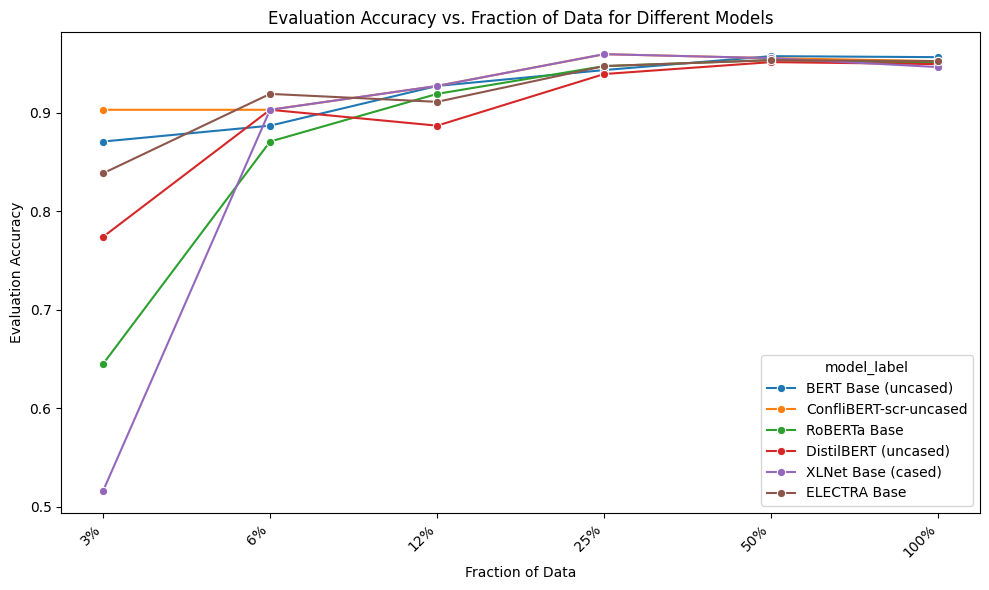

In [5]:
# prompt: fraction_label on x axis, eval_accuracy on y axis and model_label as legends for lines with different colors

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_results_df' is your DataFrame
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="fraction_label", y="eval_accuracy", hue="model_label", marker="o")

# Customize the plot
plt.xlabel("Fraction of Data")
plt.ylabel("Evaluation Accuracy")
plt.title("Evaluation Accuracy vs. Fraction of Data for Different Models")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_accuracy_vs_speed(results_df):
    """
    Creates a scatter (bubble) plot showing:
      - X-axis: eval_samples_per_second (throughput)
      - Y-axis: eval_accuracy
      - Color by model_label (hue)
      - Bubble size by fraction_raw (size)

    Assumes results_df has columns:
      - 'eval_samples_per_second'
      - 'eval_accuracy'
      - 'model_label' (string)
      - 'fraction_raw' (numeric, e.g. 0.03125, 0.0625, etc.)
    """

    # Initialize figure
    plt.figure(figsize=(8, 6))

    # Create scatterplot with Seaborn
    scatter = sns.scatterplot(
        data=results_df,
        x="eval_samples_per_second",
        y="eval_accuracy",
        hue="model_label",         # color by model
        size="fraction_raw",       # size by fraction (bubble size)
        sizes=(20, 400),          # min to max size of markers (tweak as needed)
        alpha=0.7                 # partial transparency
    )

    # Labeling
    scatter.set_title("Accuracy vs. Throughput (Samples/Sec)")
    scatter.set_xlabel("Throughput (eval_samples_per_second)")
    scatter.set_ylabel("Accuracy")

    # (Optional) Move legend to a less intrusive location
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    # Show the plot
    plt.tight_layout()
    plt.show()


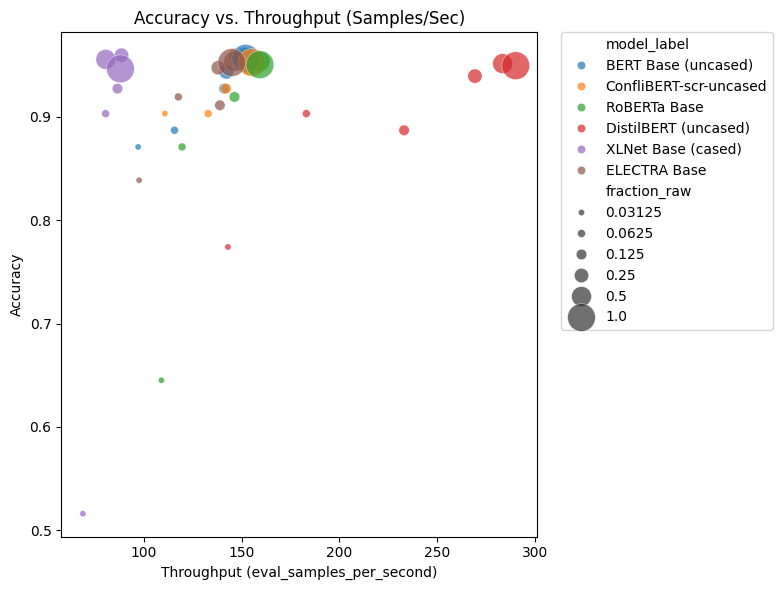

In [9]:
scatter_plot_accuracy_vs_speed(df)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(results_df, value):
    """
    Creates a heatmap where:
      - Rows = Models (model_label)
      - Columns = Fractions (fraction_label)
      - Cell Values = eval_accuracy (color-coded)
    """

    # 1. Pivot the DataFrame: index=Model, columns=Fraction, values=Accuracy
    heatmap_data = results_df.pivot(
        index="model_label",
        columns="fraction_label",
        values= value
    )

    # 2. Sort columns in ascending order of fraction if you want
    heatmap_data = heatmap_data[["3%", "6%", "12%", "25%", "50%", "100%"]]

    # 3. Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,         # writes the accuracy values in each cell
        fmt=".3f",          # format for floating point
        cmap="YlGnBu",      # color palette
        cbar_kws={"label": "Accuracy"}  # colorbar label
    )

    # 4. Labeling and layout
    plt.title(f"{value} by Model and Data Fraction")
    plt.xlabel("Data Fraction")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()


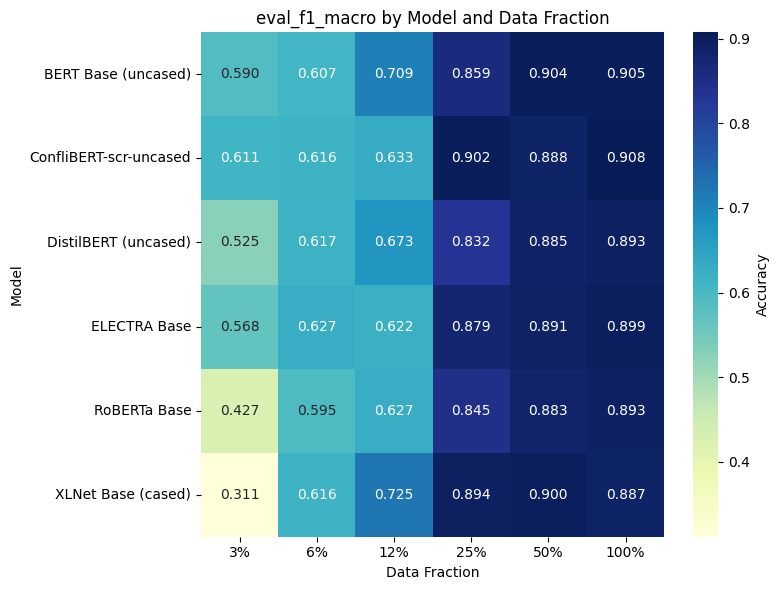

In [31]:
plot_heatmap(df, "eval_f1_macro")

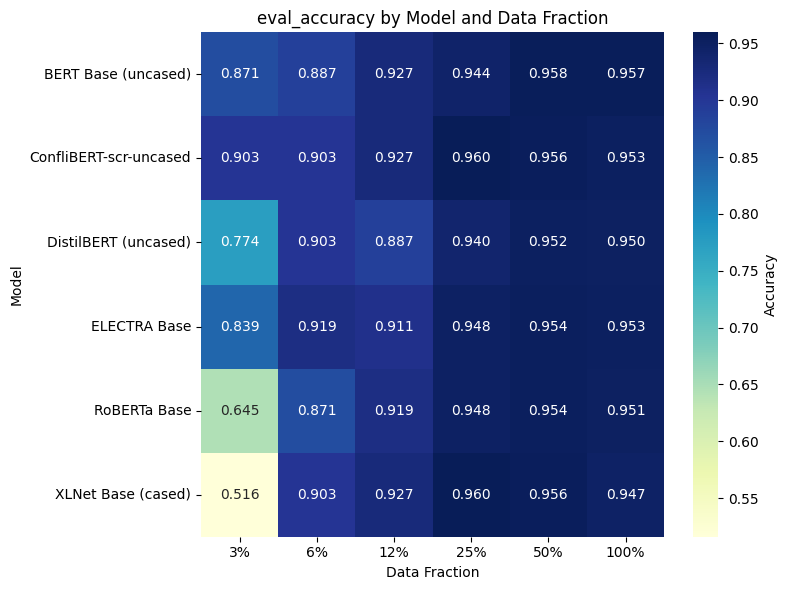

In [33]:
plot_heatmap(df, "eval_accuracy") # Change plot_heatmap_accuracy to plot_heatmap

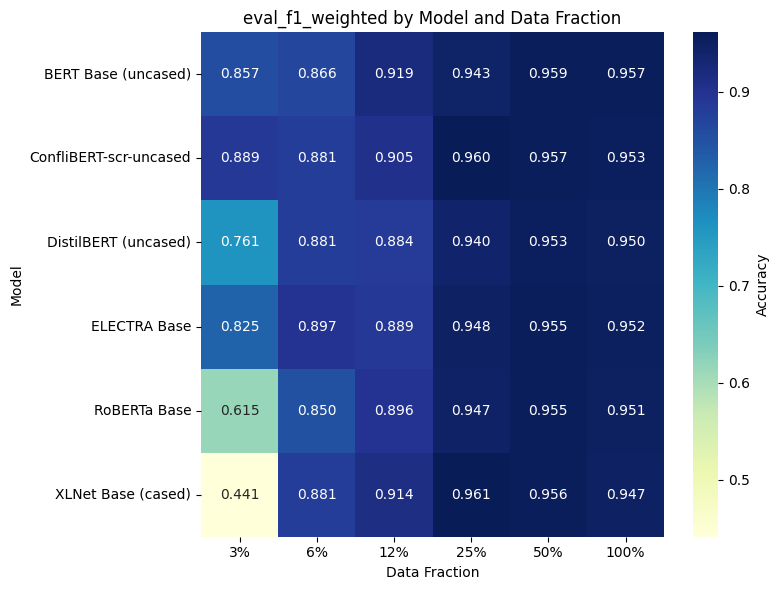

In [34]:
plot_heatmap(df, "eval_f1_weighted") # Change plot_heatmap_accuracy to plot_heatmap